In [37]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
import numpy as np

In [38]:
pd.set_option('display.max_columns', None)

men = pd.read_csv('men_results.csv')
print(men.head())

   Unnamed: 0        date home_team away_team  home_score  away_score  \
0           0  1872-11-30  Scotland   England           0           0   
1           1  1873-03-08   England  Scotland           4           2   
2           2  1874-03-07  Scotland   England           2           1   
3           3  1875-03-06   England  Scotland           2           2   
4           4  1876-03-04  Scotland   England           3           0   

  tournament  
0   Friendly  
1   Friendly  
2   Friendly  
3   Friendly  
4   Friendly  


In [39]:
women = pd.read_csv('women_results.csv')
print(women.head())

   Unnamed: 0        date home_team  away_team  home_score  away_score  \
0           0  1969-11-01     Italy     France           1           0   
1           1  1969-11-01   Denmark    England           4           3   
2           2  1969-11-02   England     France           2           0   
3           3  1969-11-02     Italy    Denmark           3           1   
4           4  1975-08-25  Thailand  Australia           3           2   

         tournament  
0              Euro  
1              Euro  
2              Euro  
3              Euro  
4  AFC Championship  


Let's quickly review the data and confirm that there are no illogical or missing entries starting with the men's soccer data.

In [40]:
print(men.info())
print(men.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44353 entries, 0 to 44352
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44353 non-null  int64 
 1   date        44353 non-null  object
 2   home_team   44353 non-null  object
 3   away_team   44353 non-null  object
 4   home_score  44353 non-null  int64 
 5   away_score  44353 non-null  int64 
 6   tournament  44353 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.4+ MB
None
         Unnamed: 0    home_score    away_score
count  44353.000000  44353.000000  44353.000000
mean   22176.000000      1.740559      1.178793
std    12803.752581      1.748722      1.394580
min        0.000000      0.000000      0.000000
25%    11088.000000      1.000000      0.000000
50%    22176.000000      1.000000      1.000000
75%    33264.000000      2.000000      2.000000
max    44352.000000     31.000000     21.000000


Scores are all positive and there are no missing values.

In [41]:
print(women.info())
print(women.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4884 non-null   int64 
 1   date        4884 non-null   object
 2   home_team   4884 non-null   object
 3   away_team   4884 non-null   object
 4   home_score  4884 non-null   int64 
 5   away_score  4884 non-null   int64 
 6   tournament  4884 non-null   object
dtypes: int64(3), object(4)
memory usage: 267.2+ KB
None
        Unnamed: 0   home_score   away_score
count  4884.000000  4884.000000  4884.000000
mean   2441.500000     2.272727     1.431409
std    1410.033688     2.736377     1.974651
min       0.000000     0.000000     0.000000
25%    1220.750000     0.000000     0.000000
50%    2441.500000     1.000000     1.000000
75%    3662.250000     3.000000     2.000000
max    4883.000000    24.000000    24.000000


The same is true for the women's set. However, there is a remarkable difference in how many records were kept. Men's data goes back to 1872 whereas women's goes back to 1969. Since we are only interested in data since 2002, we'll refine both sets.

In [42]:
men_recent = men[men['date'] >= '2002-01-01']
women_recent = women[women['date'] >= '2002-01-01']

print(f"Count of men's games: {len(men_recent)}")
print(f"Count of women's games: {len(women_recent)}")

Count of men's games: 19490
Count of women's games: 3519


We are only interested in the FIFA World Cup scores, so we will need to refine our datasets further.

In [43]:
men_fifa = men_recent[men_recent['tournament'] == 'FIFA World Cup'].copy()
women_fifa = women_recent[women_recent['tournament'] == 'FIFA World Cup'].copy()

print(f"Count of men's games: {len(men_fifa)}")
print(f"Count of women's games: {len(women_fifa)}")

Count of men's games: 384
Count of women's games: 200


We're left with 584 games in total. Now, since we want to compare the number of goals scored between men's and women's soccer matches, we will create a new attribute called goals to store the total goals scored in each game.

In [44]:
men_fifa['goals'] = men_fifa['home_score'] + men_fifa['away_score']
women_fifa['goals'] = women_fifa['home_score'] + women_fifa['away_score']

print(f"Average men's goals: {men_fifa['goals'].mean()}")
print(f"Average of women's goals: {women_fifa['goals'].mean()}")

Average men's goals: 2.5130208333333335
Average of women's goals: 2.98


Judging by the average, it looks like women's FIFA matches score more goals on average than men's. However, we'll next test whether this difference is statistically significant. Let's first visualize our distribution of goals scored to understand the distribution's structure.

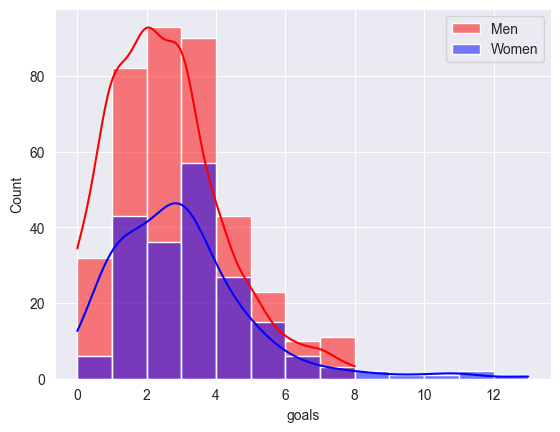

In [45]:
sns.histplot(data=men_fifa, x='goals', color='red', label='Men', kde=True, binwidth=1)
sns.histplot(data=women_fifa, x='goals', color='blue', label='Women', kde=True, alpha=0.5, binwidth=1)
plt.legend()
plt.show()

We can observe the longer tail in women's scoring that indicates the higher scoring difference, and the taller columns indicating more men's games observed. The distribution is not normal, so we will use a parametric test to determine the statistical significance. I've chosen a **Wilcoxon-Mann-Whitney** test using pingouin for this problem.

Our null hypothesis is that the mean number of goals scored in women's matches is the same as mens, and our alternative hypothesis is that the women's score more than men, so we'll instantiate the test as a one-sided right-tailed test.

In [46]:
# Create a series for each of the goal sets.
men_goals = men_fifa['goals']
women_goals = women_fifa['goals']

# Set the test to greater
mwu = pingouin.mwu(x=women_goals, y=men_goals, alternative='greater')
p_val = mwu['p-val'][0]

alpha = 0.1
if p_val < alpha:
    result = 'reject'
else:
    result = 'fail to reject'

result_dict = {"p_val": p_val, "result": result}
print(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}


## Result
Our significance level was 10% (alpha = 0.1) and the p_value was 0.005, so we can reject the null hypothesis.

Rejecting the null hypothesis indicates that there is statistically significant evidence to conclude that women's matches have more goals than men's matches in FIFA World Cup since 2002. This finding could be due to several factors, such as differences in playing style, defensive strategies, or other game dynamics between men's and women's football.